In [2]:
conda install pytorch torchvision torchaudio cpuonly -c pytorch


Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2




In [3]:
import os
import torch
import torchvision
import torchvision.transforms as t
import matplotlib.pyplot as plt
import numpy as np

In [4]:
os.listdir("C:/Users/linh0/PycharmProjects/Image-classification-project/dataset/training/training")

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [5]:
training_data_path = "C:/Users/linh0/PycharmProjects/Image-classification-project/dataset/training/training"

In [6]:
training_transform = t.Compose([t.Resize((150,150)), t.ToTensor()])

In [7]:
train_data = torchvision.datasets.ImageFolder(root = training_data_path, transform = training_transform)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 32, shuffle = False)

In [9]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        #print(images.shape)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        #print(images.shape)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

In [10]:
get_mean_and_std(train_loader)

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2099, 0.2046, 0.2005]))

In [11]:
test_data_path = "C:/Users/linh0/PycharmProjects/Image-classification-project/dataset/validation/validation"

In [12]:
# normalize image = (image - mean)/std
mean = [0.4363, 0.4328, 0.3291]
std = [0.2135, 0.2081, 0.2044]

train_transforms = t.Compose([
    t.Resize((150,150)), 
    t.RandomHorizontalFlip(),
    t.RandomRotation(10),
    t.ToTensor(),
    t.Normalize(torch.Tensor(mean), torch.Tensor(std))
    
])
#since it is a test dataset we do not flip or rotate it
test_transforms = t.Compose([
    t.Resize((150,150)), 
    t.ToTensor(),
    t.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [13]:
train_dataset = torchvision.datasets.ImageFolder(root = training_data_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)

In [14]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([0, 0, 9, 8, 0, 2])


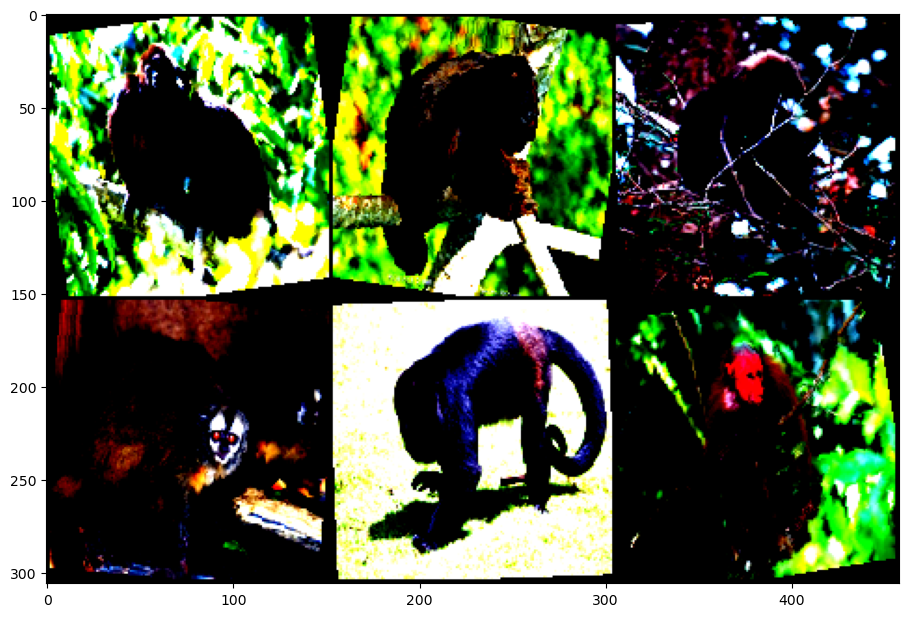

In [15]:
show_transformed_images(train_dataset)

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)
#either try 32, 64 or 128 for batch_size

In [17]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [40]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    
    for epoch in range(n_epochs):
        print('Epoch number %d '
             % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            image = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            
            optimizer.zero_grad()
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total
        
        print("    - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
             % (running_correct, total, epoch_acc, epoch_loss))
        
        eval_model_test_set(model, test_loader)
        
    print("Finished")
    return model

In [41]:
def eval_model_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
            
    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
        
    print("    - Testing dataset. Got %d out of %d images correctly (%.3f%%)"
             % (predicted_correctly_on_epoch, total, epoch_acc))
        
            

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(weights = None) #pretrained = False: weights = None; pretrained = True: weights=ResNet18_Weights.DEFAULT
num_ftrs = resnet18_model.fc.in_features
num_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, num_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()
# SGD = Stochastic gradient descent
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
# parameters controls how much the model change in respond to the standard error
# lr choose 0.1 to 0.001

In [43]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 100) #training with no weights

Epoch number 1 
    - Training dataset. Got 187 out of 1097 images correctly (17.046%). Epoch loss: 2.223
    - Training dataset. Got 54 out of 272 images correctly (19.853%)
Epoch number 2 
    - Training dataset. Got 335 out of 1097 images correctly (30.538%). Epoch loss: 1.900
    - Training dataset. Got 83 out of 272 images correctly (30.515%)
Epoch number 3 
    - Training dataset. Got 422 out of 1097 images correctly (38.469%). Epoch loss: 1.754
    - Training dataset. Got 122 out of 272 images correctly (44.853%)
Epoch number 4 
    - Training dataset. Got 529 out of 1097 images correctly (48.222%). Epoch loss: 1.417
    - Training dataset. Got 117 out of 272 images correctly (43.015%)
Epoch number 5 
    - Training dataset. Got 552 out of 1097 images correctly (50.319%). Epoch loss: 1.325
    - Training dataset. Got 105 out of 272 images correctly (38.603%)
Epoch number 6 
    - Training dataset. Got 573 out of 1097 images correctly (52.233%). Epoch loss: 1.290
    - Training d

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet18_Weights #importing the model from torchvision

resnet18_model = models.resnet18(weights=ResNet18_Weights.DEFAULT) #pretrained = False: weights = None; pretrained = True: weights=ResNet18_Weights.DEFAULT
num_ftrs = resnet18_model.fc.in_features
num_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, num_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()
# SGD = Stochastic gradient descent
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
# parameters controls how much the model change in respond to the standard error
# lr choose 0.1 to 0.001

In [53]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 20) #pretrained = True

Epoch number 1 
    - Training dataset. Got 736 out of 1097 images correctly (67.092%). Epoch loss: 1.042
    - Training dataset. Got 237 out of 272 images correctly (87.132%)
Epoch number 2 
    - Training dataset. Got 1052 out of 1097 images correctly (95.898%). Epoch loss: 0.146
    - Training dataset. Got 261 out of 272 images correctly (95.956%)
Epoch number 3 
    - Training dataset. Got 1073 out of 1097 images correctly (97.812%). Epoch loss: 0.068
    - Training dataset. Got 260 out of 272 images correctly (95.588%)
Epoch number 4 
    - Training dataset. Got 1086 out of 1097 images correctly (98.997%). Epoch loss: 0.031
    - Training dataset. Got 262 out of 272 images correctly (96.324%)
Epoch number 5 
    - Training dataset. Got 1094 out of 1097 images correctly (99.727%). Epoch loss: 0.018
    - Training dataset. Got 263 out of 272 images correctly (96.691%)
Epoch number 6 
    - Training dataset. Got 1094 out of 1097 images correctly (99.727%). Epoch loss: 0.015
    - Tra

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  